## 4. Spatial and spectral matching between photometric data cube and IFS data cube -- II. Spectral matching 

In this step, we correct for the wavelength-dependant mismatch between the IFS spectra and the photometric SEDs on pixel level. This mismatch can be caused by several factors, including systematics in the data processing (PSF matching, spatial resampling, reprojection, etc.) of the broadband imaging and IFS data and the uncertainty in the flux calibration. The spectral-mismatch correction can be performed using `piXedfit.piXedfit_spectrophotometric.match_imgifs_spectral` function. Basically, this function will perform simple SED fitting to the photometric SED of individual pixels to find best-fit model spectra. For each pixel, a wavelength-dependent ratio (between the best-fit model spectrum and the IFS spectrum) is then fit with a third-order Legendre polynomial function to get a smooth correction factor, which is then applied to correct overall shape (normalization) of the spectrum.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

### 4.1. Run the spectral matching

In [2]:
from piXedfit.piXedfit_spectrophotometric import match_imgifs_spectral

The following calculation is heavy and time-consuming, depending on the number of pixels that have spectroscopy and photometry and the number of cores used in the calculation (`nproc` parameter). It's recommended to run this calculation separately from this jupyter notebook and executed on a multicores computer (i.e., cluster). The computational time can be shorten by increasing the number of cores. A script for executing this function separately on terminal is given in `script_match_imgifs_spectral.py`. 

One of the inputs of `match_imgifs_spectral` function is `models_spec` (see the API reference [here](https://pixedfit.readthedocs.io/en/latest/piXedfit_spectrophotometric.html#piXedfit.piXedfit_spectrophotometric.match_imgifs_spectral)), which is a set of model spectra at rest-frame that can be produced using `piXedfit.piXedfit_model.save_models_rest_spec` function. User can produce their own model templates using `save_models_rest_spec` and then input it to the `match_imgifs_spectral` function. When `models_spec` is None, the function will take a model templates from piXedfit/data/mod/ ($PIXEDFIT_HOME/data/mod/) directory. For this feature to run properly, one have to make sure that a model file `s_cb_dpl_cf_nde_na_50k.hdf5` has been downloaded from [this link](https://drive.google.com/drive/folders/1YjZGg97dPT8S95NJmO5tiFH9jWhbxuVy?usp=sharing) and put it in that directory. 

In [ ]:
# script to be executed separately form jupyter notebook
specphoto_file = "specphoto_fluxmap_ngc309.fits"
nproc = 10                                              # number of cores to be used for calculation
name_out_fits = "corr_%s" % specphoto_file              # desired name for the output FITS file

match_imgifs_spectral(specphoto_file, nproc=nproc, name_out_fits=name_out_fits)

### 4.2. Check the result: spectrophotometric data cube

In [3]:
cube = fits.open("corr_specphoto_fluxmap_ngc309.fits")
cube.info()
header = cube[0].header
print (header)

Filename: corr_specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PHOTO_FLUX    1 PrimaryHDU      35   (131, 131, 12)   float64   
  1  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  2  WAVE          1 ImageHDU         7   (1901,)   float64   
  3  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  4  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  5  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  6  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  7  MOD_WAVE      1 ImageHDU         7   (1553,)   float64   
  8  MOD_FLUX      1 ImageHDU         9   (131, 131, 1553)   float64   
  9  CORR_FACTOR    1 ImageHDU         9   (131, 131, 1901)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / numbe

In [4]:
# region covered by the photometry
photo_region = cube['PHOTO_REGION'].data
# region covered by the IFU
spec_region = cube['SPEC_REGION'].data
# wavelength grids
wave = cube['wave'].data
# maps of photometric fluxes and their uncertainties
photo_flux = cube['PHOTO_FLUX'].data
photo_flux_err = cube['PHOTO_FLUXERR'].data
# maps of spatially resolved spectra and their uncertainties
spec_flux = cube['SPEC_FLUX'].data
spec_flux_err = cube['SPEC_FLUXERR'].data
# get model: best-fit to photometric SED
mod_wave = cube['MOD_WAVE'].data
mod_flux = cube['MOD_FLUX'].data
corr_factor = cube['corr_factor'].data

# get unit
unit = header['unit']

cube.close()

### 4.2.1. Check the coverages of the photometry and spectroscopy

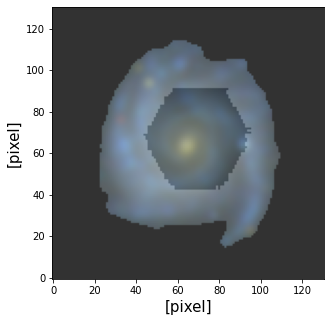

In [6]:
%matplotlib inline

from astropy.visualization import make_lupton_rgb

g = photo_flux[3]*10
r = photo_flux[4]*10
i = photo_flux[5]*10

rgb_default = make_lupton_rgb(i, r, g)

### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(5,5))
f1 = plt.subplot()
plt.xlabel('[pixel]', fontsize=15)
plt.ylabel('[pixel]', fontsize=15)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(spec_region, origin='lower', cmap='Greys', alpha=0.2)

### 4.2.2. Check the SEDs of some pixels

In [7]:
# get photometric and spectroscopic SEDs of pixels:
#transpose (band,y,x) => (y,x,band):
pix_photo_SED = np.transpose(photo_flux, axes=(1, 2, 0))*unit           ## erg/s/cm^2/A
pix_photo_SED_err = np.transpose(photo_flux_err, axes=(1, 2, 0))*unit

#transpose (wavelength,y,x) => (y,x,wavelength):
pix_spec_SED = np.transpose(spec_flux, axes=(1, 2, 0))*unit
pix_spec_SED_err = np.transpose(spec_flux_err, axes=(1, 2, 0))*unit
pix_mod_spec_SED = np.transpose(mod_flux, axes=(1, 2, 0))*unit
pix_corr_factor = np.transpose(corr_factor, axes=(1, 2, 0))

In [9]:
# get filters
nbands = header['nfilters']
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(header[str_temp])

# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

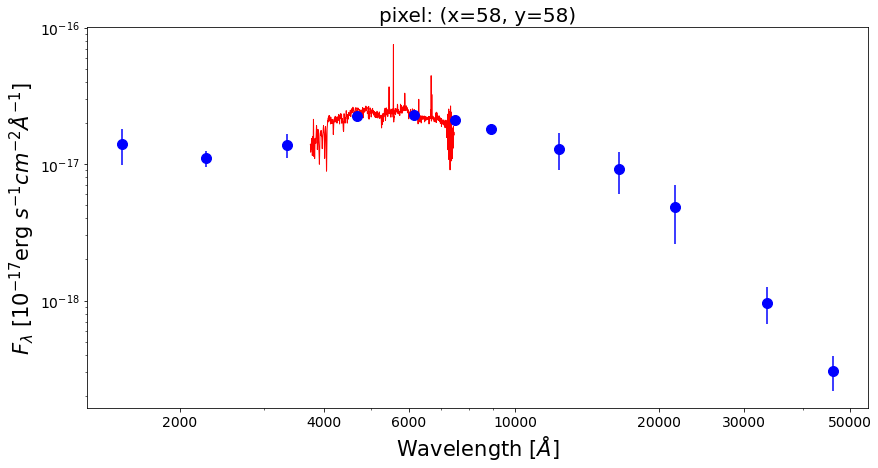

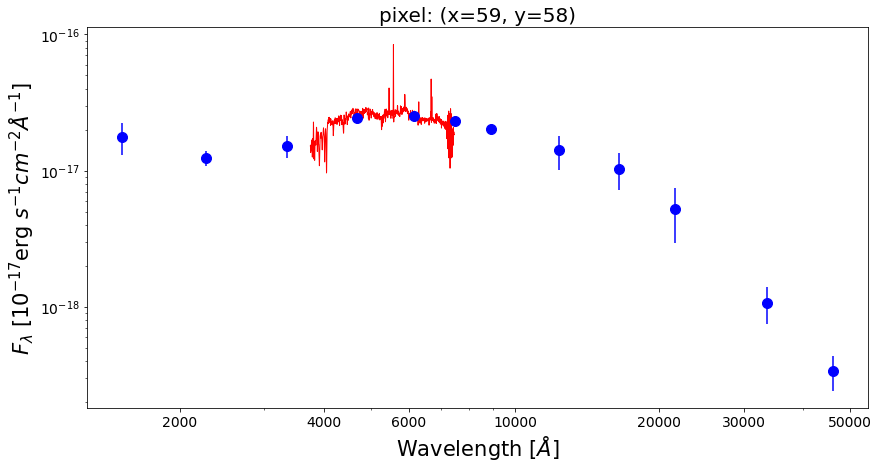

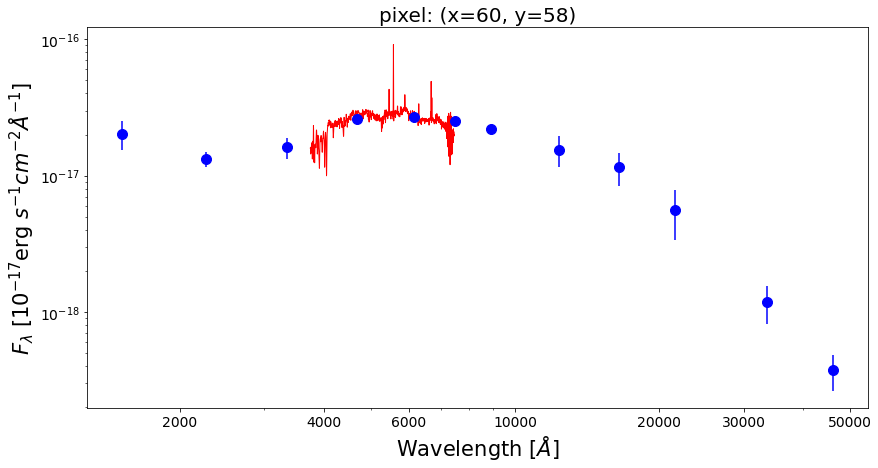

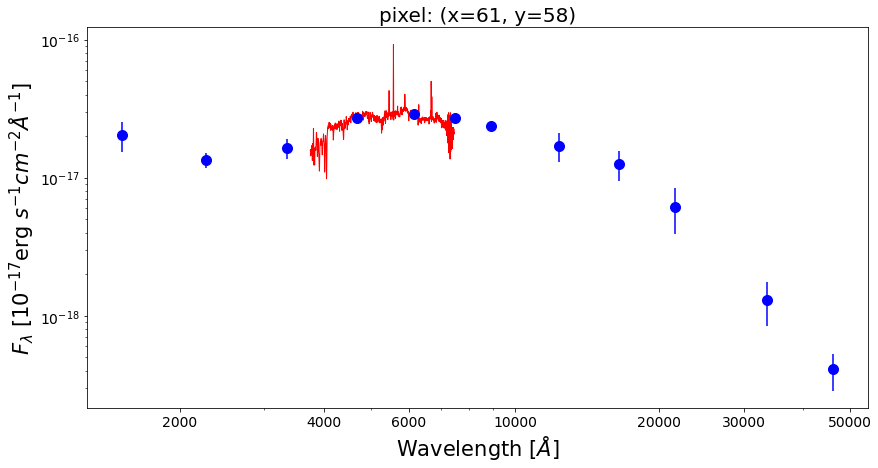

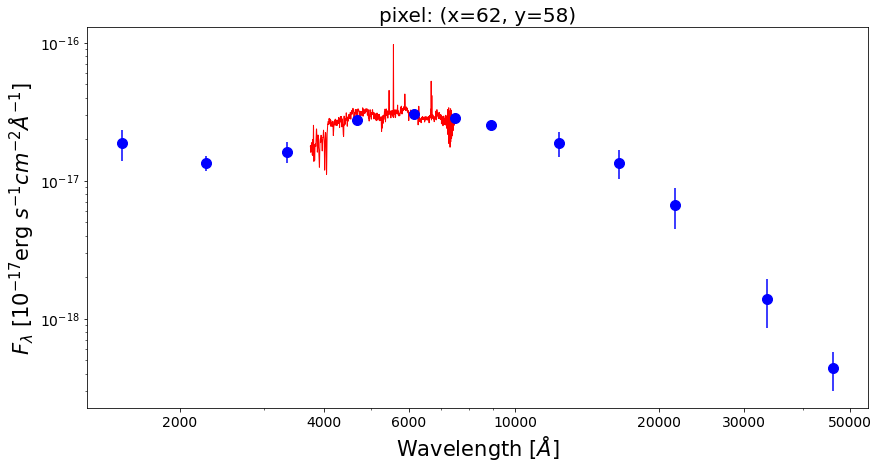

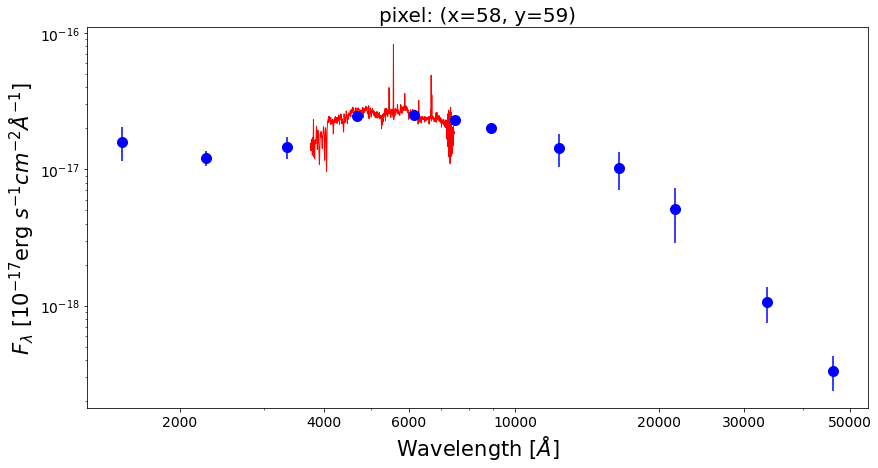

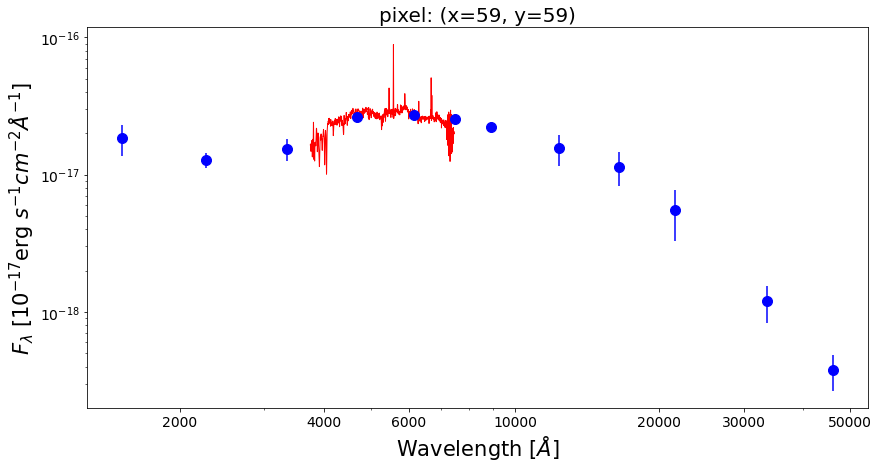

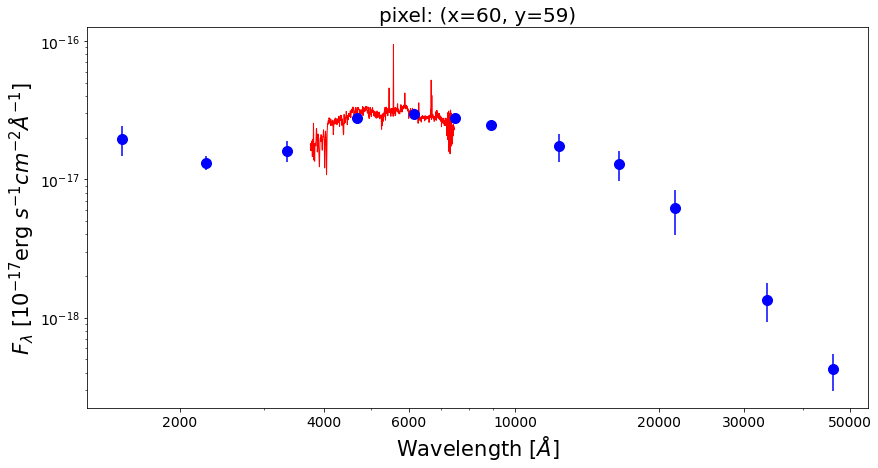

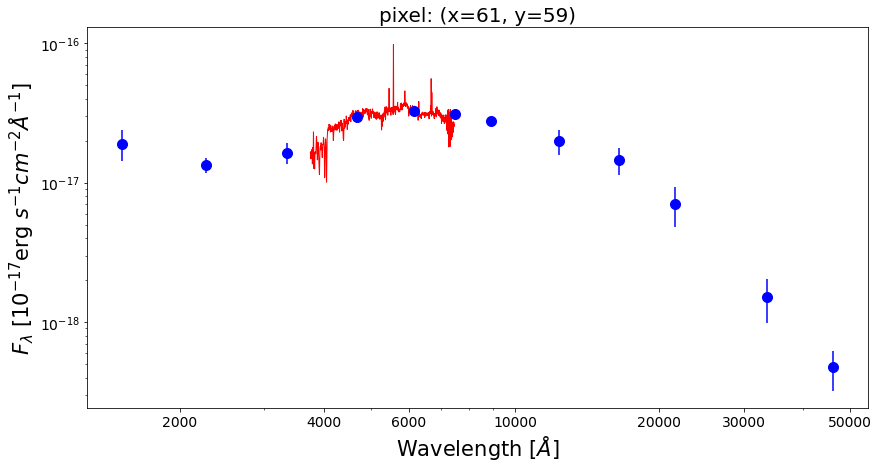

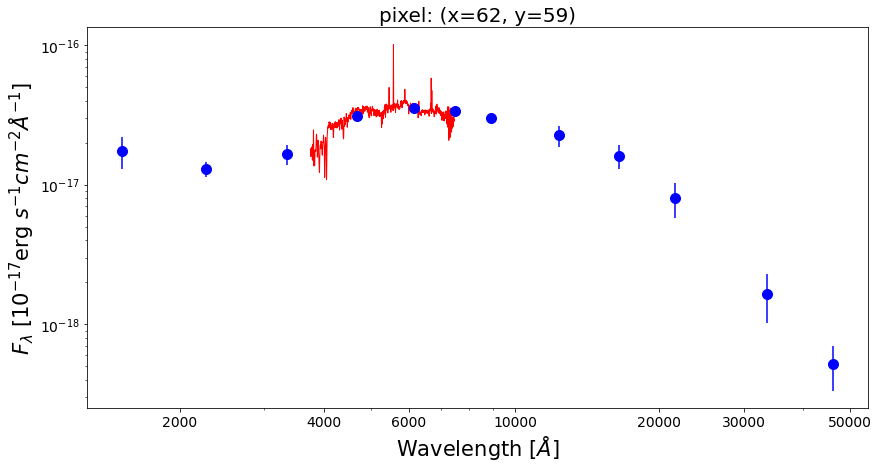

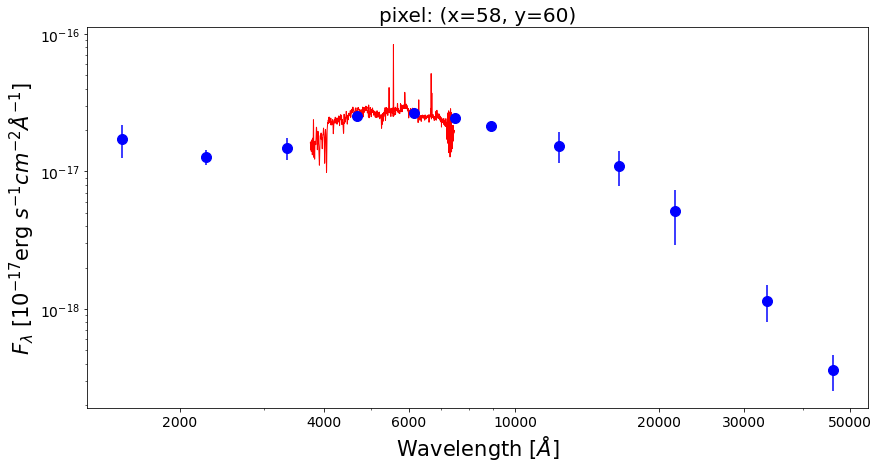

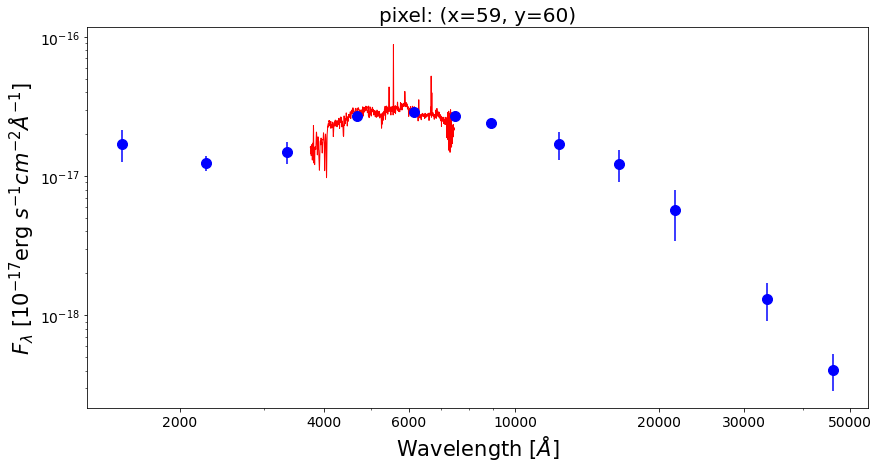

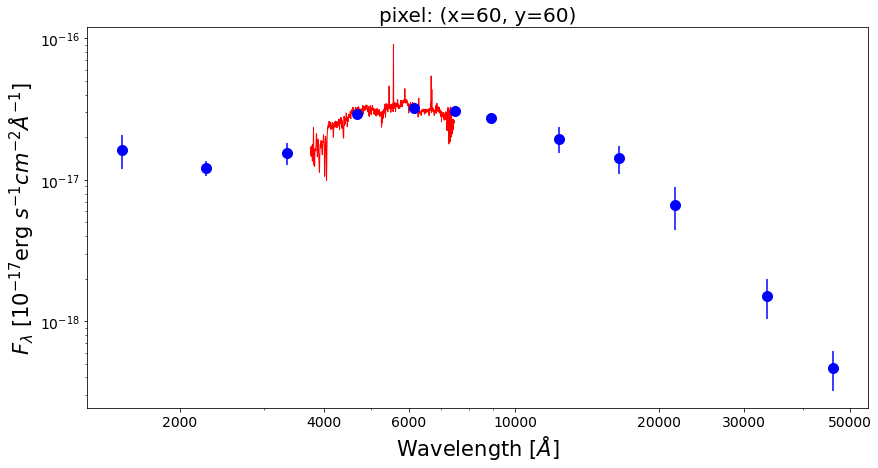

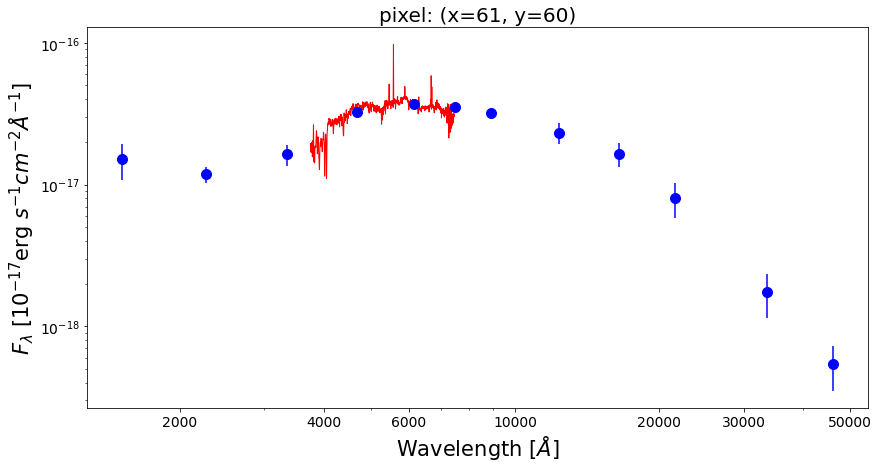

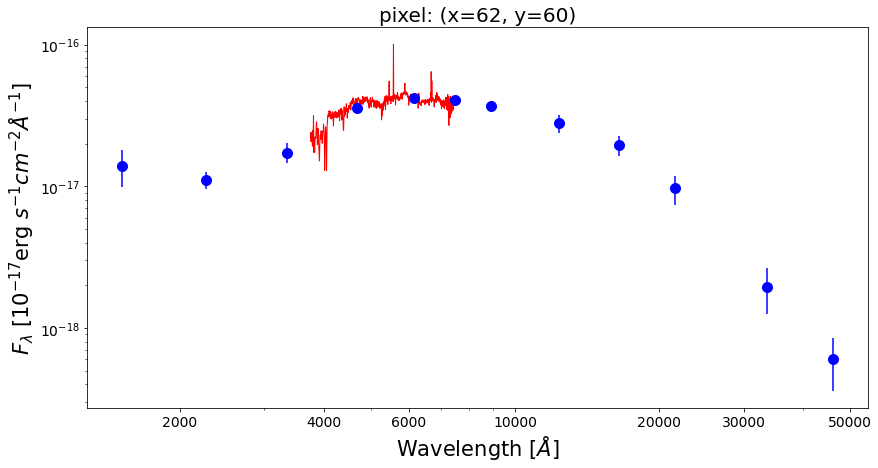

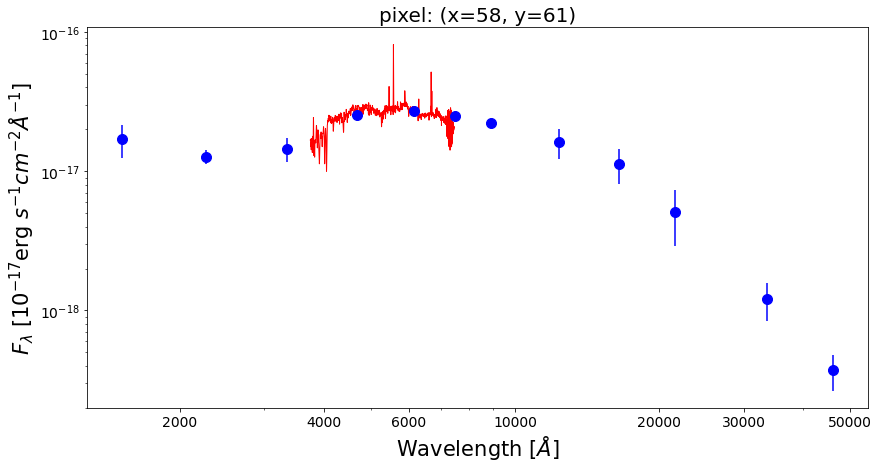

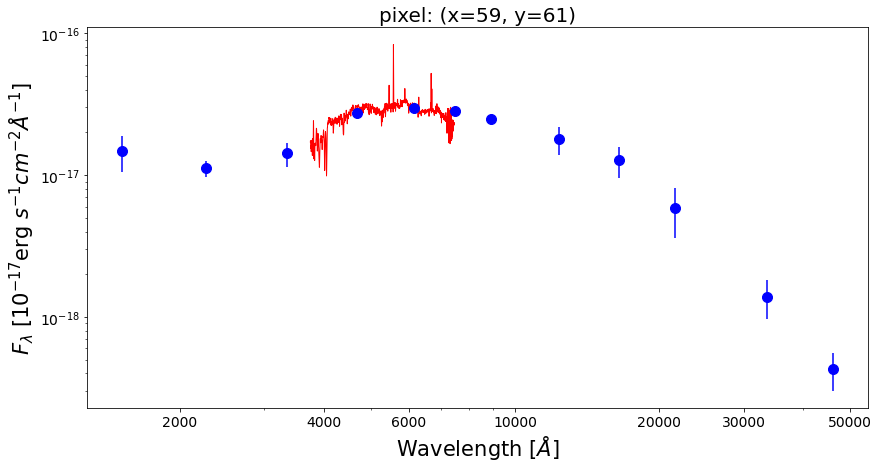

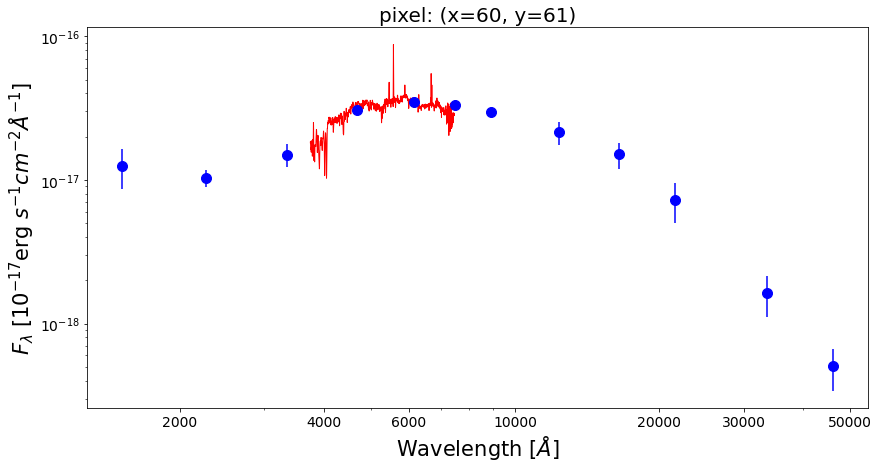

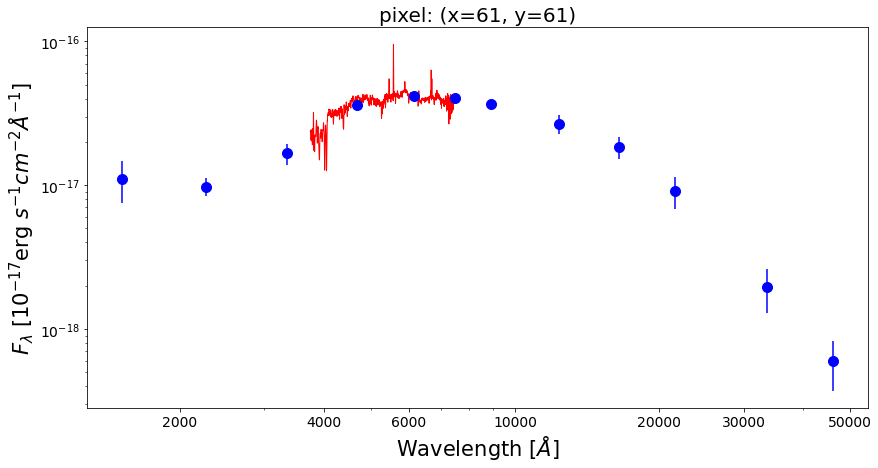

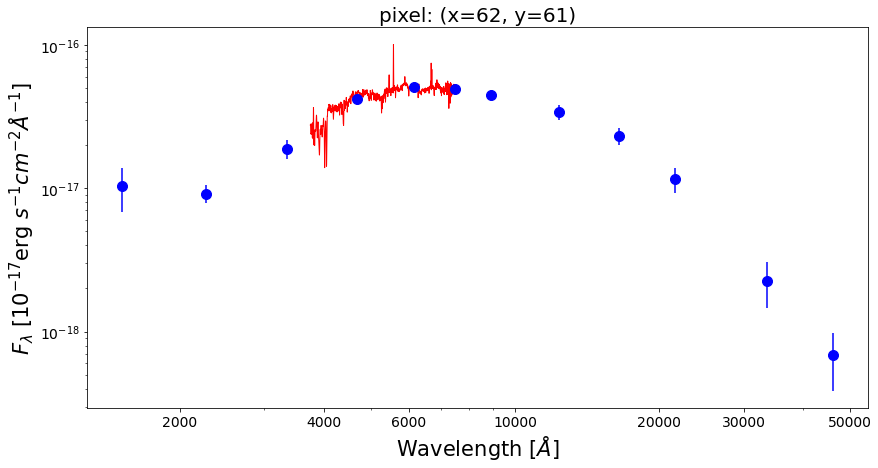

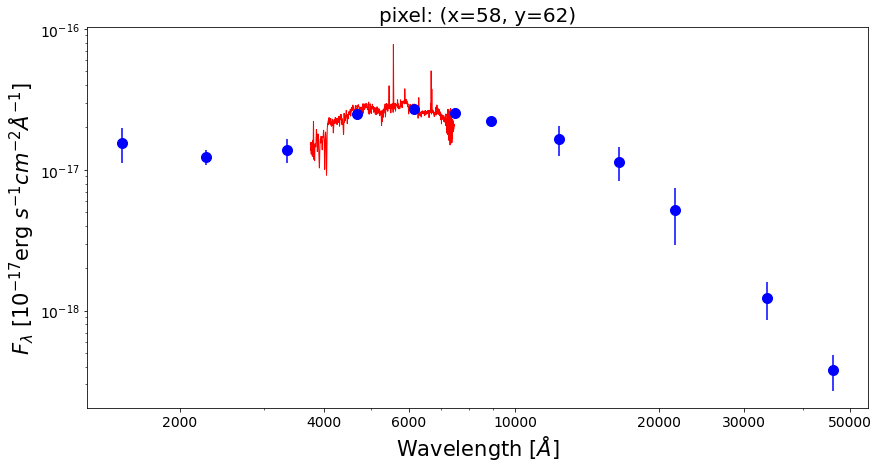

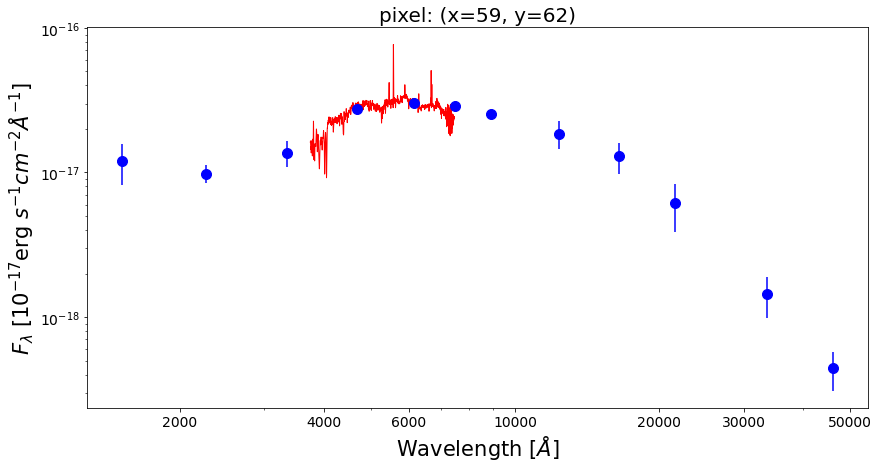

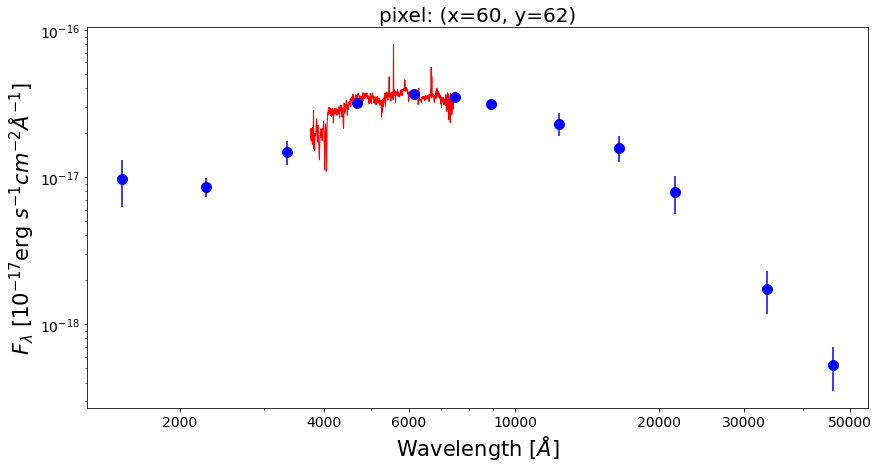

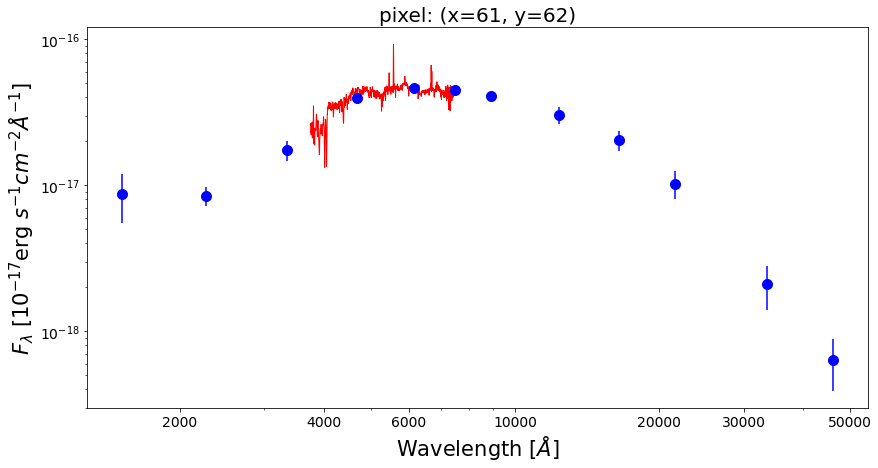

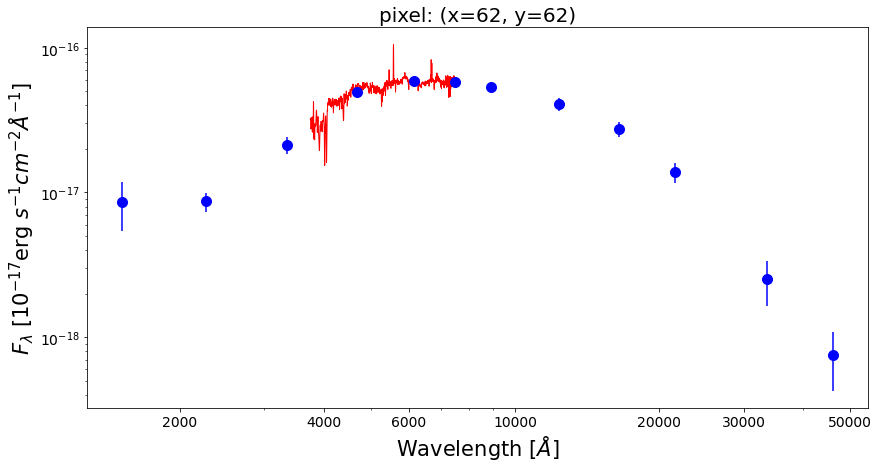

In [10]:
from matplotlib.ticker import ScalarFormatter

# Optional: cut the spectra around the edge to exclude those commonly uncertain fluxes
nwaves = len(wave)

for yy in range(58,63):
    for xx in range(58,63): 
        if spec_region[yy][xx]==1:
            fig1 = plt.figure(figsize=(14,7))
            f1 = plt.subplot()   
            plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
            f1.set_yscale('log')
            f1.set_xscale('log')
            plt.setp(f1.get_yticklabels(), fontsize=14)
            plt.setp(f1.get_xticklabels(), fontsize=14)
            plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
            plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
            xticks = [2000,4000,6000,10000,20000,30000,50000]
            plt.xticks(xticks)
            #plt.xlim(3000,10000)
            #plt.ylim(1.0e-19,8e-16)
            for axis in [f1.xaxis]:
                axis.set_major_formatter(ScalarFormatter())
            
            # Optional: cut the spectra around the edge to exclude 
            # those commonly uncertain fluxes
            plt.plot(wave[20:nwaves-20], pix_spec_SED[yy][xx][20:nwaves-20], lw=1.0, color='red')
            plt.errorbar(photo_wave, pix_photo_SED[yy][xx], yerr=pix_photo_SED_err[yy][xx], 
                         markersize=10,color='blue', fmt='o')